## Import Library

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

sns.set(style="whitegrid")

### Load Data

In [3]:
df_users = pd.read_excel("users.xlsx")
df_trackings = pd.read_excel("developer_journey_trackings.xlsx")
df_completions = pd.read_excel("developer_journey_completions.xlsx")
df_submissions = pd.read_excel("developer_journey_submissions.xlsx")
df_exam_results = pd.read_excel("exam_results.xlsx")
df_exam_registrations = pd.read_excel("exam_registrations.xlsx")


## Data Preparation

In [4]:
df_trackings['last_viewed'] = pd.to_datetime(df_trackings['last_viewed'], errors='coerce')
df_trackings['first_opened_at'] = pd.to_datetime(df_trackings['first_opened_at'], errors='coerce')
df_trackings['completed_at'] = pd.to_datetime(df_trackings['completed_at'], errors='coerce')

## Feature Engineering (5 Final Features)

In [5]:
# F1: Consistency (Total Active Days)
consistency_features = df_trackings.groupby('developer_id')['last_viewed'].agg(
    lambda x: x.dt.date.nunique() if not x.isnull().all() else 0
).reset_index(name='total_active_days')

# F2: Speed (Avg Completion Time in hours)
completed_tutorials = df_trackings.dropna(subset=['completed_at', 'first_opened_at']).copy()
completed_tutorials['time_to_complete'] = (
    completed_tutorials['completed_at'] - completed_tutorials['first_opened_at']
).dt.total_seconds() / 3600
avg_time_to_complete = completed_tutorials.groupby('developer_id')['time_to_complete'] \
    .mean().reset_index(name='avg_completion_time_hours')

# F3: Volume (Total Journeys Completed)
total_journeys_completed = df_completions.groupby('user_id').size() \
    .reset_index(name='total_journeys_completed')
total_journeys_completed.rename(columns={'user_id': 'developer_id'}, inplace=True)

# F4: Reflection (Rejection Ratio)
total_submissions = df_submissions.groupby('submitter_id').size() \
    .reset_index(name='total_submissions')
total_submissions.rename(columns={'submitter_id': 'developer_id'}, inplace=True)

rejected_submissions = df_submissions[df_submissions['status'] == -1] \
    .groupby('submitter_id').size().reset_index(name='rejected_submissions')
rejected_submissions.rename(columns={'submitter_id': 'developer_id'}, inplace=True)

# F5: Quality (Avg Exam Score)
df_exam_link = df_exam_registrations[['id', 'examinees_id']].rename(
    columns={'id': 'exam_registration_id', 'examinees_id': 'developer_id'}
)
df_exam_data = df_exam_results.merge(df_exam_link, on='exam_registration_id', how='inner')
quality_features = df_exam_data.groupby('developer_id').agg(
    avg_exam_score=('score', 'mean')
).reset_index()

### Merge All Features

In [6]:
df_final = df_users[['id', 'name']].rename(
    columns={'id': 'developer_id', 'name': 'developer_name'}
).copy()

features_list = [
    consistency_features,
    avg_time_to_complete,
    total_journeys_completed,
    total_submissions,
    rejected_submissions,
    quality_features
]

for df_f in features_list:
    df_final = df_final.merge(df_f, on='developer_id', how='left')

# Hitung rejection_ratio dan handle NaN
df_final['total_submissions'] = df_final['total_submissions'].fillna(0)
df_final['rejected_submissions'] = df_final['rejected_submissions'].fillna(0)

df_final['rejection_ratio'] = np.where(
    df_final['total_submissions'] > 0,
    df_final['rejected_submissions'] / df_final['total_submissions'],
    0
)

# Isi NaN lain (user tidak aktif di metrik tersebut) dengan 0
df_final = df_final.fillna(0)

### Final Feature Selection

In [7]:
FINAL_FEATURES = [
    'total_active_days',         # Consistency
    'avg_completion_time_hours', # Speed
    'total_journeys_completed',  # Volume
    'rejection_ratio',           # Reflection
    'avg_exam_score'             # Quality
]

X_final = df_final[FINAL_FEATURES]


## Exploratory Data Analysis (EDA)

=== Statistik Deskriptif Fitur ===
       total_active_days  avg_completion_time_hours  total_journeys_completed  \
count          31.000000                  31.000000                 31.000000   
mean          268.548387                1198.655948                 33.290323   
std           194.182532                1431.150324                 20.388221   
min             1.000000                   0.002051                  0.000000   
25%           161.000000                 184.896841                 20.500000   
50%           239.000000                 534.510714                 36.000000   
75%           338.500000                1714.586928                 46.500000   
max           777.000000                5708.506936                 82.000000   

       rejection_ratio  avg_exam_score  
count        31.000000       31.000000  
mean          0.364079       74.953604  
std           0.219352       22.047179  
min           0.000000        0.000000  
25%           0.243506       6

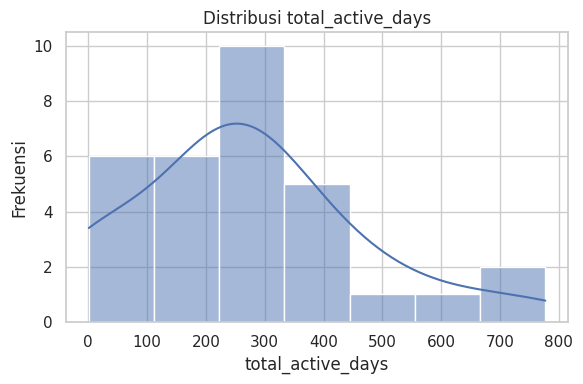

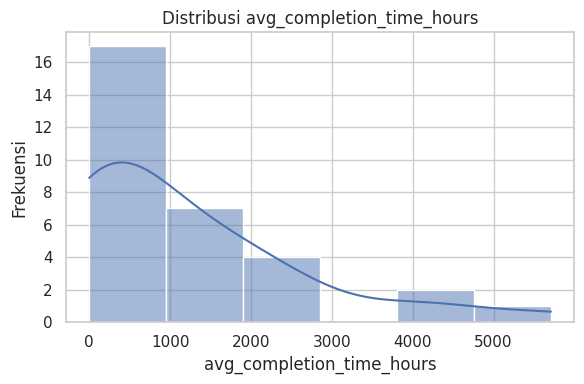

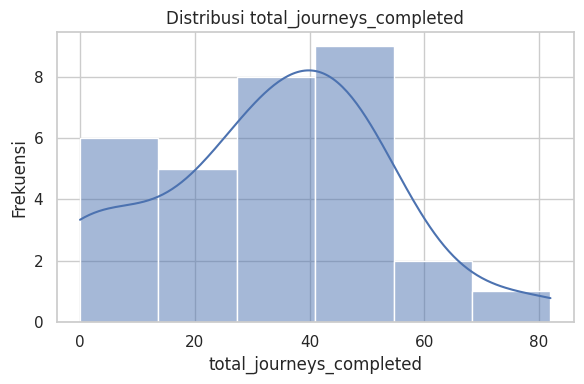

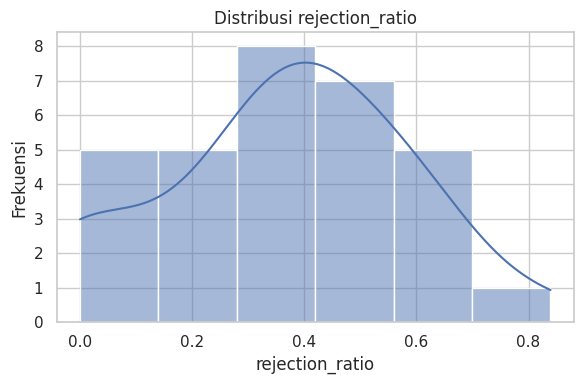

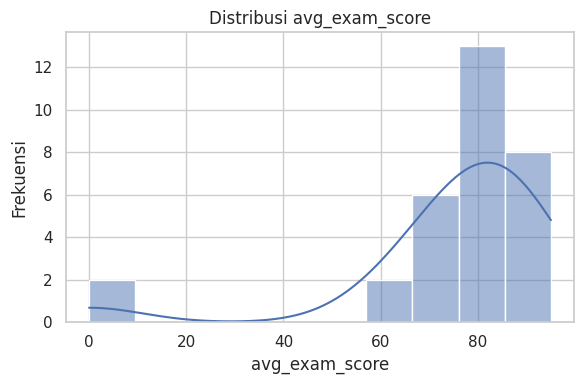

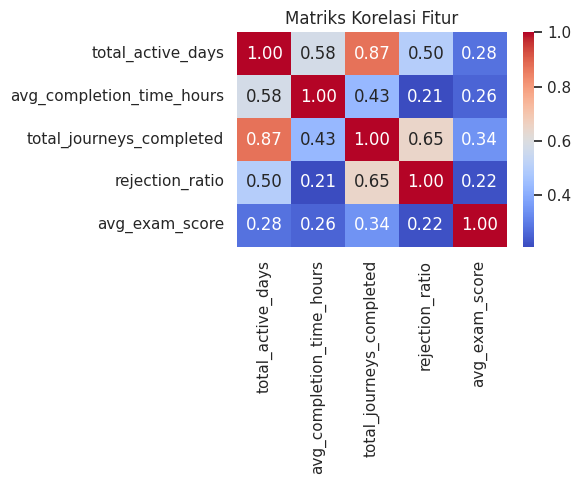

In [8]:
print("=== Statistik Deskriptif Fitur ===")
print(X_final.describe())

# Distribusi tiap fitur (histogram / KDE)
for col in FINAL_FEATURES:
    plt.figure(figsize=(6, 4))
    sns.histplot(X_final[col], kde=True)
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')
    plt.tight_layout()
    plt.show()

# Korelasi antar fitur
plt.figure(figsize=(6, 5))
corr_matrix = X_final.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Matriks Korelasi Fitur')
plt.tight_layout()
plt.show()

### Hapus Outliers using Z-Score

In [9]:
# Menghitung Z-Score untuk setiap fitur
z_scores = np.abs(zscore(X_final))

# Menentukan batas Z-Score untuk mendeteksi outlier (misalnya > 3)
# Gunakan .any(axis=1): baris dianggap outlier jika minimal satu fitur ekstrem
outliers = (z_scores > 3).any(axis=1)

# Menampilkan data yang dianggap outlier
df_outliers = df_final[outliers]
print("=== Outliers detected ===")
print(df_outliers)

# Menghapus outlier
df_final_no_outliers = df_final[~outliers].reset_index(drop=True)
X_final_no_outliers = df_final_no_outliers[FINAL_FEATURES]


=== Outliers detected ===
   developer_id          developer_name  total_active_days  \
1        938276  Nur Rizki Adi Prasetyo                318   
5       5181638      Anggit andreansyah                  1   
7       5410865    ramadhan oktarizaldi                  1   

   avg_completion_time_hours  total_journeys_completed  total_submissions  \
1                5708.506936                      19.0               59.0   
5                   0.002051                       0.0                0.0   
7                   0.002139                       0.0                0.0   

   rejected_submissions  avg_exam_score  rejection_ratio  
1                  25.0       84.202247         0.423729  
5                   0.0        0.000000         0.000000  
7                   0.0        0.000000         0.000000  


**Profil singkat:**

**Nur Rizki**

avg_completion_time_hours = 5708 (super ekstrem)
total_active_days = 318, journeys = 19, score = 84
Ini jelas outlier dari sisi kecepatan  hal ini wajar dibuang.

**Anggit & Ramadhan**

total_active_days = 1, journeys = 0, submissions = 0, score = 0
Ini kelompok user yang nyaris tidak menggunakan platform.


### Standardization (Scaling)

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final_no_outliers)


### Find Optimal K Using Elbow Method and Silhouette Score

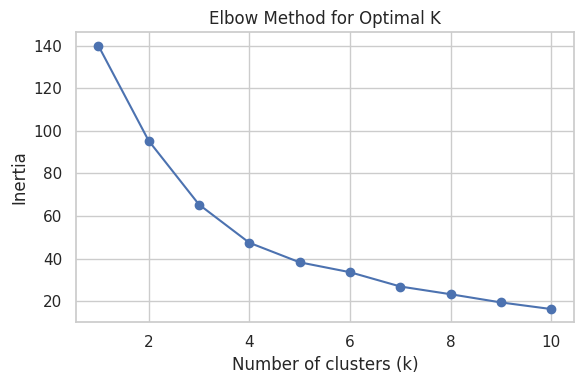

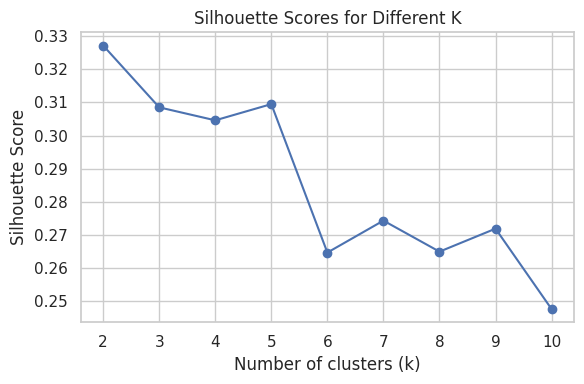

K terbaik berdasarkan silhouette (otomatis): 2
OPTIMAL_K yang dipakai untuk training: 4


In [11]:
# Elbow Method
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.tight_layout()
plt.show()

# Silhouette Score
silhouette_scores = []
K_range_sil = range(2, 11)  # silhouette butuh k >= 2
for k in K_range_sil:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels_tmp = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels_tmp)
    silhouette_scores.append(score)

plt.figure(figsize=(6, 4))
plt.plot(K_range_sil, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different K')
plt.tight_layout()
plt.show()

# Pilih K optimal (bisa manual dari grafik, atau otomatis dari silhouette)
best_k = np.argmax(silhouette_scores) + 2  # +2 karena mulai dari k=2
print(f"K terbaik berdasarkan silhouette (otomatis): {best_k}")

# Kalau ingin pakai nilai manual (misal hasil diskusi tim):
OPTIMAL_K = 4  # ubah jika mau ikuti best_k
print(f"OPTIMAL_K yang dipakai untuk training: {OPTIMAL_K}")


### Final K-Means Modeling (K = OPTIMAL_K)

In [12]:
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
df_final_no_outliers['cluster_label'] = cluster_labels


### Analysis of Clusters

In [13]:
# Distribusi jumlah user per cluster
cluster_counts = df_final_no_outliers['cluster_label'].value_counts().sort_index()
print("\n=== Cluster Distribution (jumlah user per cluster) ===")
print(cluster_counts)

# Rata-rata fitur per cluster
cluster_means = df_final_no_outliers.groupby('cluster_label')[FINAL_FEATURES].mean()
print("\n=== Mean of Features by Cluster ===")
print(cluster_means)


=== Cluster Distribution (jumlah user per cluster) ===
cluster_label
0     4
1    11
2     7
3     6
Name: count, dtype: int64

=== Mean of Features by Cluster ===
               total_active_days  avg_completion_time_hours  \
cluster_label                                                 
0                      13.000000                   4.900470   
1                     244.363636                 819.637470   
2                     531.714286                2690.719033   
3                     257.166667                 596.529330   

               total_journeys_completed  rejection_ratio  avg_exam_score  
cluster_label                                                             
0                              3.000000         0.041667       84.471596  
1                             37.818182         0.401695       85.758393  
2                             56.000000         0.424252       79.631920  
3                             32.166667         0.551277       66.784556  


**Mapping konsep ↔ hasil cluster Berdasarkan statistik cluster: **

**0	= Fast Learner**,Hari aktif sangat sedikit, waktu per modul sangat cepat, journey sedikit, skor ujian cukup baik	 Sprinter Pasif	fast learner (low consistency)

**1 = Consistent Fast Learner – Performer Stabil**, Hari aktif cukup tinggi, journey banyak, skor ujian tertinggi, rejection ratio sedang

**2 = Reflective Deep Learner**, Hari aktif sangat tinggi, journey banyak, waktu per modul sangat lama, skor cukup

**3 = Struggling Learner – Eksperimental Berisiko**, 	Hari aktif sedang, journey sedang, rejection ratio tinggi, skor ujian paling rendah


### Visualization of Clusters using PCA

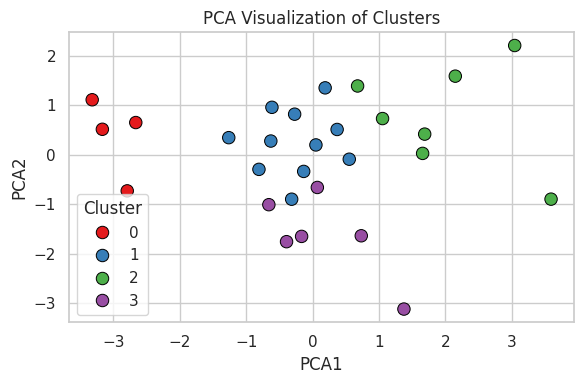

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
# gunakan langsung array cluster_labels supaya berbaris dengan PCA
df_pca['cluster_label'] = cluster_labels

plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_pca,
    x='PCA1',
    y='PCA2',
    hue='cluster_label',
    palette='Set1',
    s=80,
    edgecolor='black'
)
plt.title('PCA Visualization of Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

## Silhouette Score (Evaluation)

In [15]:
score = silhouette_score(X_scaled, cluster_labels)
print(f"\nSilhouette Score for K={OPTIMAL_K}: {score:.4f}")


Silhouette Score for K=4: 0.3046


Silhouette 0,30:

Bukan jelek, tapi juga bukan “super strong separation”.

Masih cukup wajar untuk data perilaku manusia yang noisy.

“Berdasarkan nilai silhouette, konfigurasi dua cluster memberikan pemisahan terbaik secara kuantitatif. Namun demikian, untuk tujuan desain fitur AI Learning Insight dan kebutuhan segmentasi produk, dipilih empat cluster karena memberikan granularity insight yang lebih kaya dengan nilai silhouette sebesar 0,3046 yang masih berada pada kategori moderat.”

### Model Serialization (Save for Deployment)

In [16]:
# Save the Scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Save the K-Means Model
with open('kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

# Save Cluster Centers and Inertia
with open('kmeans_centers.pkl', 'wb') as file:
    pickle.dump(kmeans.cluster_centers_, file)

with open('kmeans_inertia.pkl', 'wb') as file:
    pickle.dump(kmeans.inertia_, file)

# Save the final result for documentation (termasuk label cluster)
df_final_no_outliers.to_csv("clustered_students.csv", index=False)
print("\nFile 'clustered_students.csv' berhasil disimpan.")


File 'clustered_students.csv' berhasil disimpan.
